# Analyse the traffic patterns and Rate Limit Enforcements

In [29]:
%pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


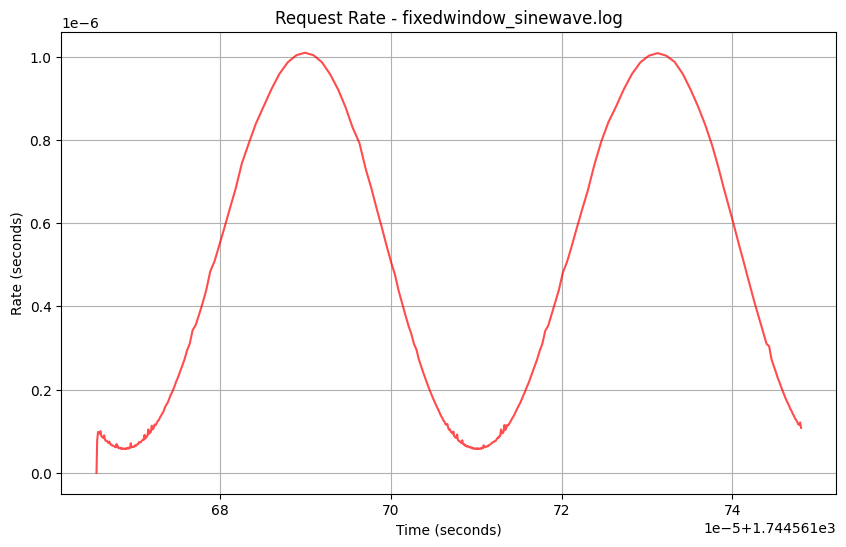

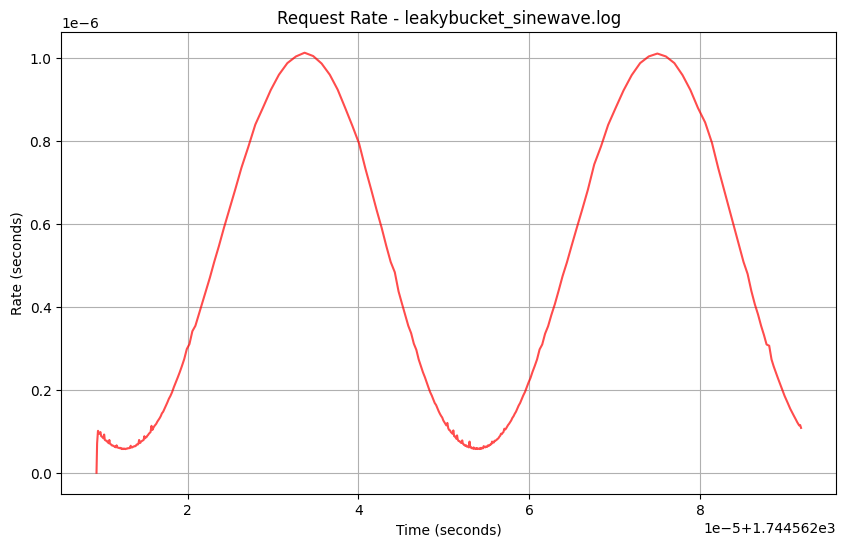

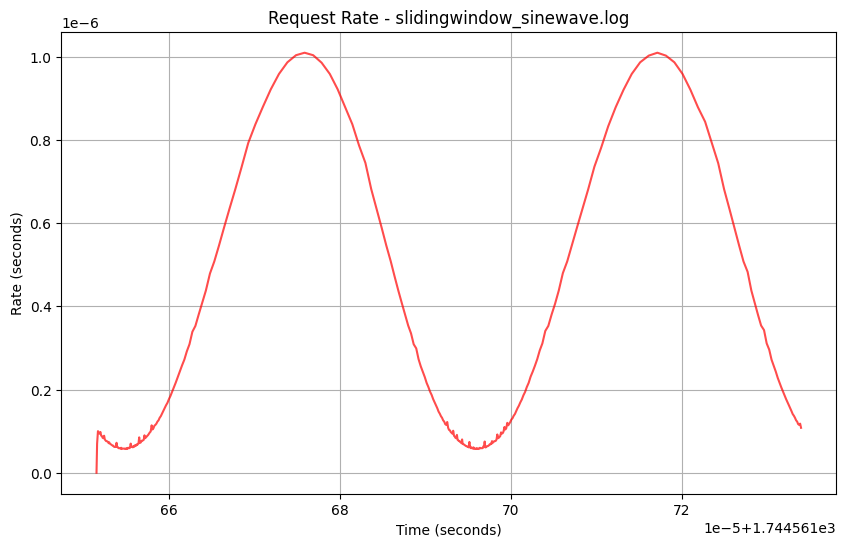

In [30]:
import os
import re
import pandas as pd

import matplotlib.pyplot as plt

# Initialize an empty list to store timestamps
timestamps = []

# Define the logs folder path
logs_folder = '../logs'

# Regular expression to match the log line with incoming messages
log_pattern = re.compile(r'(\d+).*correlationId-\d+.*incoming')

# Iterate through all files in the logs folder
for log_file in os.listdir(logs_folder):
    log_file_path = os.path.join(logs_folder, log_file)
    if os.path.isfile(log_file_path):
        timestamps = []  # Reset timestamps for each file
        with open(log_file_path, 'r') as file:
            for line in file:
                match = log_pattern.match(line)
                if match:
                    # Extract the timestamp (in nanoseconds)
                    timestamps.append(int(match.group(1)))

        # Convert timestamps to a pandas DataFrame
        df = pd.DataFrame({'Timestamp': timestamps})

        # Convert nanoseconds to seconds for better readability
        df['Timestamp'] = df['Timestamp'] / 1e9
        
        # Calculate the rate of requests (requests per second)
        df['Rate'] = df['Timestamp'].diff().fillna(0)

        # Plot the rate of requests for the current file
        plt.figure(figsize=(10, 6))
        plt.plot(df['Timestamp'], df['Rate'], color='red', alpha=0.7)
        plt.title(f'Request Rate - {log_file}')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Rate (seconds)')
        plt.grid(True)
        plt.show()

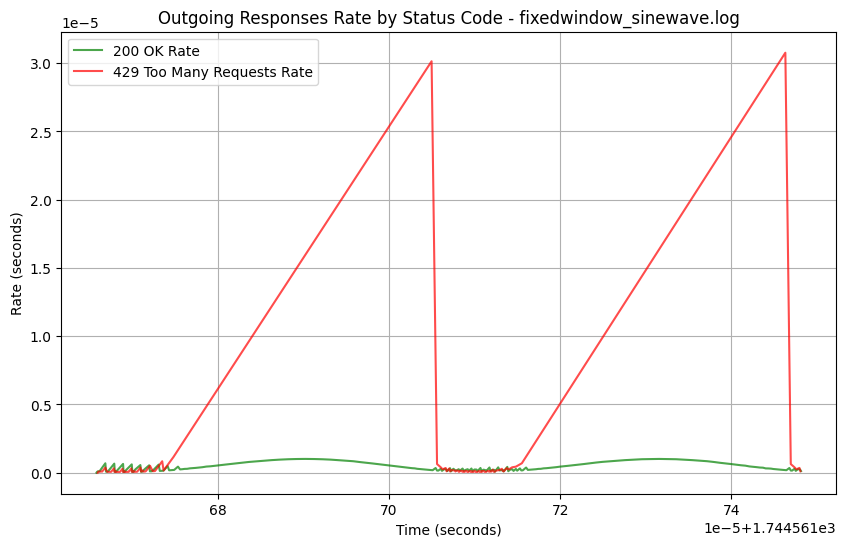

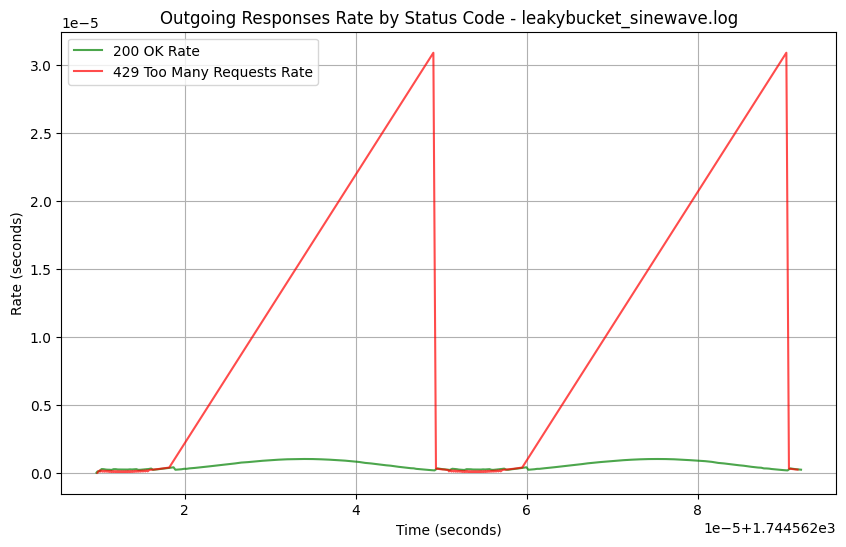

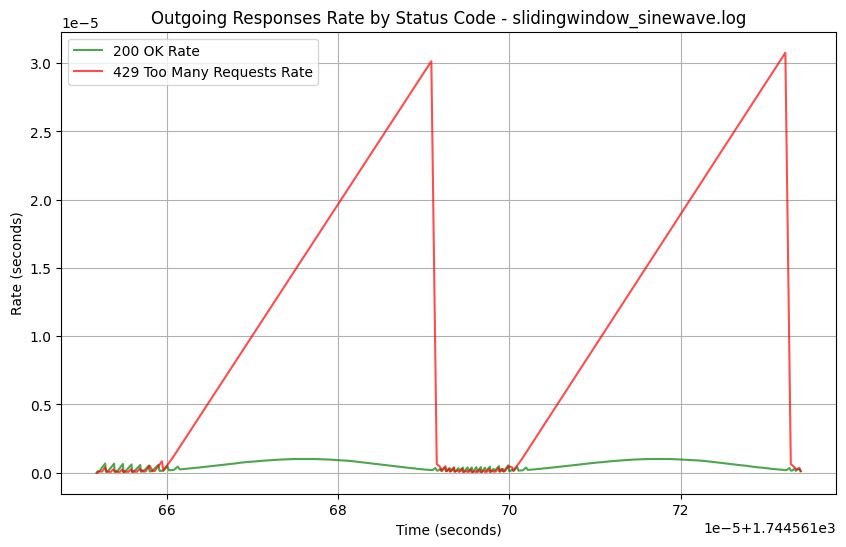

In [31]:
# Regular expression to match the log line with outgoing responses and status codes
response_pattern = re.compile(r'(\d+).*CorrelationId: correlationId-\d+, Status code: (\d{3})')

# Iterate through all files in the logs folder
for log_file in os.listdir(logs_folder):
    log_file_path = os.path.join(logs_folder, log_file)
    if os.path.isfile(log_file_path):
        timestamps_200 = []
        timestamps_429 = []
        with open(log_file_path, 'r') as file:
            for line in file:
                match = response_pattern.match(line)
                if match:
                    # Extract the timestamp (in nanoseconds) and status code
                    timestamp = int(match.group(1))
                    status_code = int(match.group(2))
                    if status_code == 200:
                        timestamps_200.append(timestamp)
                    elif status_code == 429:
                        timestamps_429.append(timestamp)

        # Convert timestamps to seconds for better readability
        timestamps_200 = [t / 1e9 for t in timestamps_200]
        timestamps_429 = [t / 1e9 for t in timestamps_429]

        # Create a DataFrame for plotting
        df_200 = pd.DataFrame({'Timestamp': timestamps_200, 'Status': ['200'] * len(timestamps_200)})
        df_429 = pd.DataFrame({'Timestamp': timestamps_429, 'Status': ['429'] * len(timestamps_429)})
        df_combined = pd.concat([df_200, df_429])

        # Compute the rate of requests for each status code
        df_200['Rate'] = df_200['Timestamp'].diff().fillna(0)
        df_429['Rate'] = df_429['Timestamp'].diff().fillna(0)

        # Plot the multi-line graph
        plt.figure(figsize=(10, 6))
        if not df_200.empty:
            plt.plot(df_200['Timestamp'], df_200['Rate'], label='200 OK Rate', color='green', alpha=0.7)
        if not df_429.empty:
            plt.plot(df_429['Timestamp'], df_429['Rate'], label='429 Too Many Requests Rate', color='red', alpha=0.7)
        plt.title(f'Outgoing Responses Rate by Status Code - {log_file}')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Rate (seconds)')
        plt.legend()
        plt.grid(True)
        plt.show()

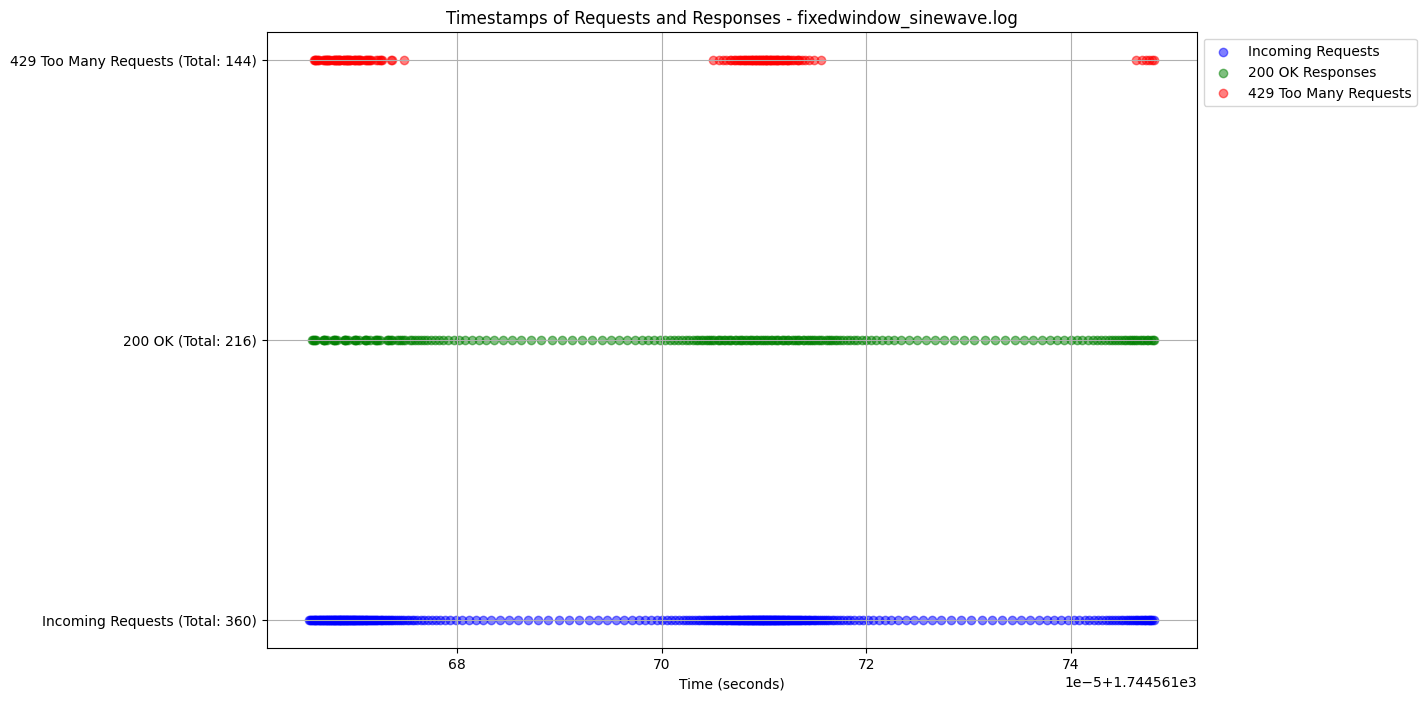

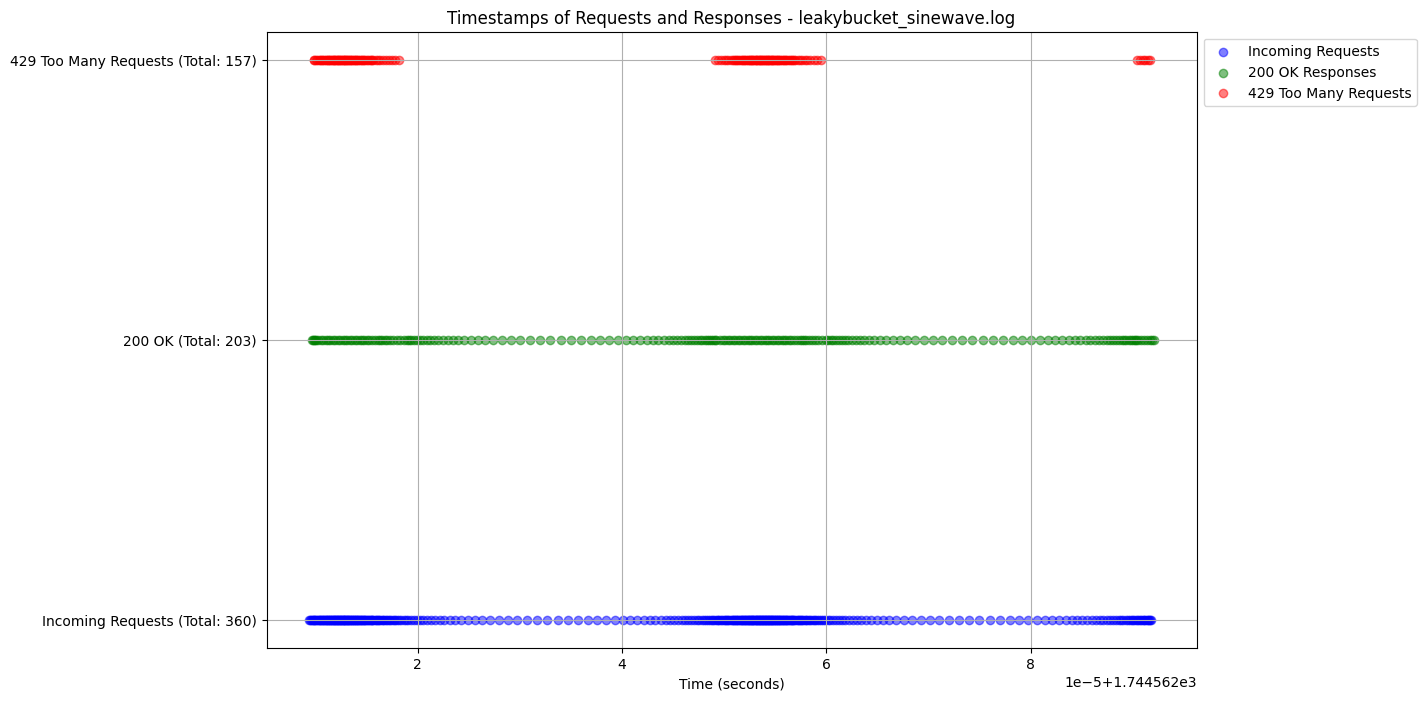

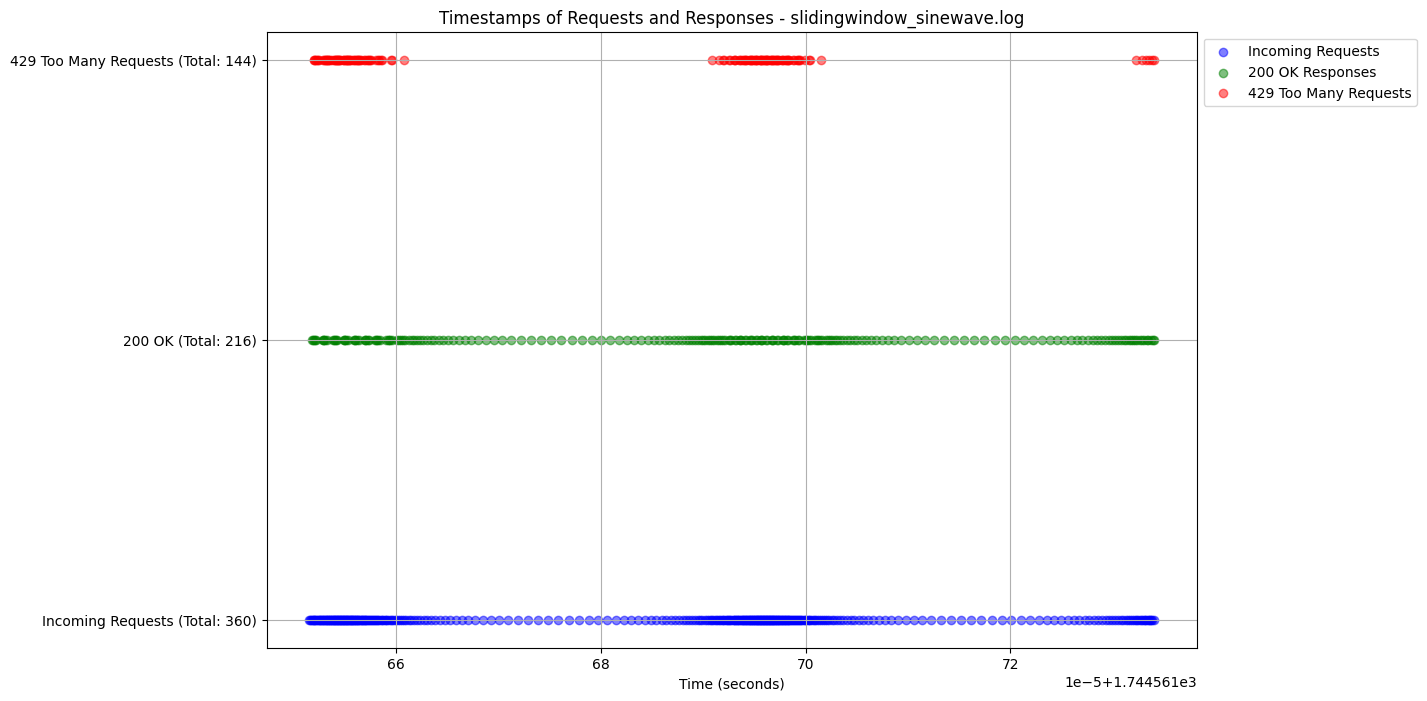

In [38]:
# Iterate through all files in the logs folder
for log_file in os.listdir(logs_folder):
    log_file_path = os.path.join(logs_folder, log_file)
    if os.path.isfile(log_file_path):
        # Extract incoming request timestamps
        timestamps = []
        with open(log_file_path, 'r') as file:
            for line in file:
                match = log_pattern.match(line)
                if match:
                    timestamps.append(int(match.group(1)) / 1e9)  # Convert to seconds

        # Extract outgoing response timestamps and status codes
        timestamps_200 = []
        timestamps_429 = []
        with open(log_file_path, 'r') as file:
            for line in file:
                match_response = response_pattern.match(line)
                if match_response:
                    timestamp = int(match_response.group(1)) / 1e9  # Convert to seconds
                    status_code = int(match_response.group(2))
                    if status_code == 200:
                        timestamps_200.append(timestamp)
                    elif status_code == 429:
                        timestamps_429.append(timestamp)

        # Create DataFrames
        df = pd.DataFrame({'Timestamp': timestamps})
        df_200 = pd.DataFrame({'Timestamp': timestamps_200, 'Status': ['200'] * len(timestamps_200)})
        df_429 = pd.DataFrame({'Timestamp': timestamps_429, 'Status': ['429'] * len(timestamps_429)})

        # Plot the values
        plt.figure(figsize=(12, 8))
        plt.scatter(df['Timestamp'], [1] * len(df), label='Incoming Requests', color='blue', alpha=0.5)
        if not df_200.empty:
            plt.scatter(df_200['Timestamp'], [2] * len(df_200), label='200 OK Responses', color='green', alpha=0.5)
        if not df_429.empty:
            plt.scatter(df_429['Timestamp'], [3] * len(df_429), label='429 Too Many Requests', color='red', alpha=0.5)

        # Add title and labels
        total_requests = len(df)
        total_200 = len(df_200)
        total_429 = len(df_429)

        plt.title(f'Timestamps of Requests and Responses - {log_file}')
        plt.xlabel('Time (seconds)')
        plt.yticks([1, 2, 3], [
            f'Incoming Requests (Total: {total_requests})', 
            f'200 OK (Total: {total_200})', 
            f'429 Too Many Requests (Total: {total_429})'
        ])
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        
        plt.grid(True)
        plt.show()
